In [ ]:
#One time step ERA interim

In [7]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime
# Load data
file = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann'
ds = xr.open_dataset(file)

ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)

lat = ds.lat
lon = ds.lon

output_era = {}
vars = ['cape', 'tau_x', 'tau_y', 'wspd10']

# Define bounding box
lat_min, lat_max = 30, 40
lon_min, lon_max = -90, -70

# Find indices within the bounding box
lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Subset the data
for var in vars:
    if var in ds.variables:
        output_era[var] = ds[var][:, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1]

output_era["dates"] = ds['time']
# decoded_times = times.dt  # Access time properties

# # Add dates to a new variable or use directly
# ds['dates'] = decoded_times

ds.close()

import pandas as pd

# Extract time coordinate as pandas datetime objects
dates_era = pd.to_datetime(output_era["dates"].values)

# Define the filtering range
start_date = datetime.datetime(2002, 1, 1)
end_date = datetime.datetime(2003, 1, 31)

# Apply the date filter
m_era = (dates_era >= start_date)& (dates_era <= end_date)

# Filtered dates (optional: store back in output_era if needed)
filtered_dates = dates_era[m_era]

In [8]:
print(filtered_dates)

DatetimeIndex(['2002-07-01 06:00:00'], dtype='datetime64[ns]', freq=None)


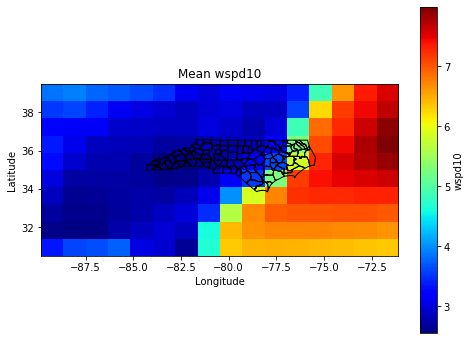

In [9]:
info = {
    #'cape': {'cmap': 'terrain', 'title': "Convective Available Potential Energy (J/kg)"},
    #'tau_x': {'cmap': 'RdBu_r', 'title': "Surface Zonal Wind Stress (dPa)"},
    #'tau_y': {'cmap': 'Blues', 'title': 'Surface Meridional Wind Stress (dPa)'},
    'wspd10': {'cmap': 'jet', 'title': 'Wind Speed at 10m (m/s)'}
}

# Load the shapefile
shapefile_path = "/data/HW/HW2/NCDOT_County_Boundaries.shp"
counties = gpd.read_file(shapefile_path)
counties = counties.to_crs(epsg=4326)
var = 'wspd10'

# Calculate the mean over the desired axis (e.g., time axis)
data_to_plot = np.mean(output_era[var], axis=0)

# Define the extent for the plot using lon and lat
lon_min, lon_max = np.min(lon[lon_idx]), np.max(lon[lon_idx])
lat_min, lat_max = np.min(lat[lat_idx]), np.max(lat[lat_idx])

# Plot using imshow
plt.figure(figsize=(8, 6))

plt.imshow(
    data_to_plot,
    cmap=plt.get_cmap(info[var]['cmap']),
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin='lower',  # Ensure the origin is at the bottom-left
)

counties.boundary.plot(ax=plt.gca(), color='black', linewidth=1) #add the mess grid as the x and Y
plt.colorbar(label=var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mean {var}')

plt.show()